# BBC News Topic Modeling Using Non-Negative Matrix Factorization 

This repository features an implementation of Non-Negative Matrix Factorization for clustering BBC News articles into multiple categories. Developed using Scikit-Learn and Python, the project aims to apply Natural Language Processing (NLP) over a collection of BBC News texts, extract latent features through NMF, and identify relevant "topics". Topic modeling is an unsupervised learning approach to document clustering based on the topics of their content. The performance of this unsupervised algorithm will be compared to that of several supervised algorithms, including Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Classification, and Random Forest. 

The [BBC News Classification dataset](https://www.kaggle.com/competitions/learn-ai-bbc/overview) is used for training and testing the models. The dataset consists of 2225 articles, each categorized under one of 5 categories: business, entertainment, politics, sport or tech. The data is divided into two sets: a training set with 1,490 articles and a test set with 735 articles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import spacy
import en_core_web_sm
from string import punctuation
import re  
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.corpus import wordnet as wn 
from nltk import pos_tag
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [3]:
# Load the BBC News dataset
train_set = pd.read_csv("BBC News Train.csv")
test_set = pd.read_csv("BBC News Test.csv")

y_true = pd.read_csv("BBC News Sample Solution.csv")

# Exploratory Data Analysis 

The dataset used for text classification is not evenly distributed across the five categories: Sports, Business, Technology, and two additional categories. Here's a brief overview of the distribution:

- Sports has the largest number of articles.
- Business follows as the second most frequent category.
- Technology has the lowest number of articles among the categories.

While the data is not equally distributed, the differences in frequencies across the categories do not appear to be too extreme. This moderate imbalance is important to consider as it may affect the performance of classification models and may necessitate techniques to address class imbalance during training.

The data also contains duplicated samples. The duplicates will be removed so that they do not bias performance of the model. 


In [4]:
train_set.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
test_set.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [7]:
train_set.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [8]:
duplicates = train_set[train_set.duplicated(subset = ['Text'], keep = False)]
df_sorted = duplicates.sort_values(by='Text')
df_sorted.head(10)

,ArticleId,Text,Category
494,1326,ask jeeves joins web log market ask jeeves has...,tech
228,1098,ask jeeves joins web log market ask jeeves has...,tech
1430,1042,aviator creator in oscars snub the man who s...,entertainment
695,374,aviator creator in oscars snub the man who s...,entertainment
443,1847,blind student hears in colour a blind studen...,tech
1317,145,blind student hears in colour a blind studen...,tech
406,1218,bortolami predicts dour contest italy skipper ...,sport
637,427,bortolami predicts dour contest italy skipper ...,sport
1455,1600,britons fed up with net service a survey condu...,tech
1123,478,britons fed up with net service a survey condu...,tech


In [9]:
# There are 50 articles that are duplicated. Need to remove them 

train_set_cleaned = train_set.drop_duplicates(subset=['Text', 'Category'])

In [10]:
df = pd.DataFrame(train_set_cleaned.Category.value_counts())
df = df.rename(columns = {"Category": "Counts"})
df['Category'] = df.index 
df.reset_index(drop=True, inplace=True)
df['perc'] = round(100*df['Counts']/df['Counts'].sum(), 2)

df

,Counts,Category,perc
0,342,sport,23.75
1,335,business,23.26
2,266,politics,18.47
3,263,entertainment,18.26
4,234,tech,16.25


(array([335.,   0., 234.,   0.,   0., 266.,   0., 342.,   0., 263.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

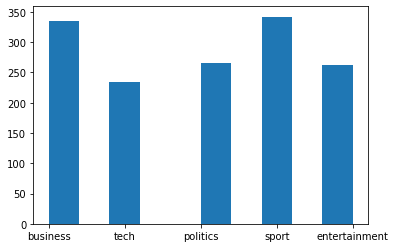

In [11]:
plt.hist(train_set_cleaned.Category)

(0.0, 25.0)

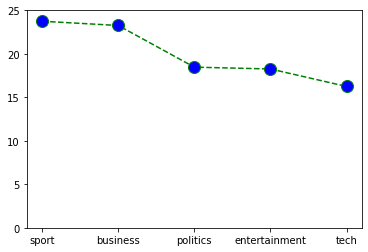

In [12]:
plt.plot(df['Category'],df['perc'], color='green', linestyle='dashed', marker='o',
     markerfacecolor='blue', markersize=12)

plt.ylim(0, 25)



# Text Processing 

Text classification can be done using natural language processing (NLP) and various supervised learning algorithms. NLP enables computers to understand and interpret human language, making it possible to process vast amounts of text data in meaningful ways. Machine learning, specifically neural networks, have significantly enhances the ability of computers to understand the context of complex human language. 

Before inputting text data into models, it must be transformed into a structured format that models can understand.This preprocessing involves several crucial steps: 

1. Removing Blank Rows: Ensuring that the dataset is clean and free from empty entries.
2. Converting Text to Lowercase: Standardizing text by converting all characters to lowercase.
3. Word Tokenization: Breaking down a stream of text into meaningful elements called tokens.
4. Removing Stop Words: Eliminating common words (like "and," "the," "is") that do not add significant meaning to the text.
5. Removing Non-Alphabetic Text: Filtering out non-alphabetic characters to focus on meaningful content.
6. Word Lemmatization: Reducing words to their base or root form, with lemmatization distinguishing word meanings based on parts of speech, unlike stemming, which lacks this contextual understanding.


In our topic modeling approach, we will focus on processing the text data by retaining only the "nouns." This method is based on the assumption that nouns carry substantial information that can effectively help in inferring the underlying topics within the documents. By filtering out other parts of speech and focusing on nouns, we aim to simplify the text representation while preserving the essential content necessary for topic modeling.

In [13]:
df1 = train_set_cleaned.copy()

In [14]:

nlp = en_core_web_sm.load()

def extract_nouns(texts, batch_size=500, n_process=4):
    output = []
    # Use nlp.pipe with batching and multiple processes
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        nouns = " ".join(
            token.lemma_ for token in doc 
            if token.pos_ == 'NOUN' and not token.is_stop and not token.is_digit and token.text not in punctuation and len(token.text) > 1
        )
        
        if len(nouns) > 2:
            output.append(nouns)
            
    return output
        



In [15]:
# Process training data
df1['Text_Nouns_only'] = extract_nouns(df1['Text'])

# Process test data 
test_set['Text_Nouns_only'] = extract_nouns(test_set['Text'])

df1.head()

,ArticleId,Text,Category,Text_Nouns_only
0,1833,worldcom ex-boss launches defence lawyers defe...,business,boss launch defence lawyer ebber battery fraud...
1,154,german business confidence slides german busin...,business,business confidence business confidence hope r...
2,1101,bbc poll indicates economic gloom citizens in ...,business,gloom citizen majority nation service poll wor...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle govern choice hardware phone firm ha...
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss payout enron director settlement de...


In [16]:
from collections import Counter

# Tokenize the text
df1['tokenized_text'] = df1['Text_Nouns_only'].apply(lambda x: x.split())

# Flatten the list of tokens
all_words = [word for tokens in df1['tokenized_text'] for word in tokens]

# Get word frequency
word_freq = Counter(all_words)

# Convert to DataFrame for better readability
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)


# Count article length 
article_len = [len(article) for article in df1['tokenized_text']]

df1['article_len'] = article_len


## Exploratory Text Analysis 

Article Length: 
- Average Number of Extracted Nouns per Article: 90 words.
- Distribution of Article Lengths: 75% of the articles have fewer than 112 words.
- Largest Article: Contains 720 nouns.

Word Reuse
- Average Frequency of Word Reuse: Each word is reused approximately 13 times on average.
- Distribution of Word Reuse: 75% of the extracted nouns are repeated fewer than 7 times.
- Top 20 words are occur more than 450 times across all articles 

Category Insights
- Sports Articles: Tend to have fewer extracted nouns compared to other categories.
- Technology Articles: Use the largest number of extracted nouns on average.

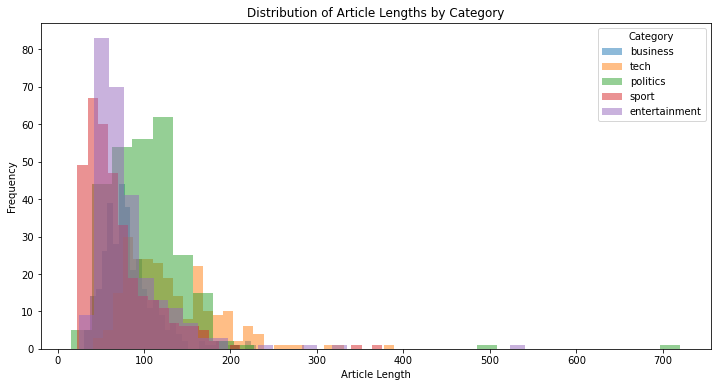

In [17]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Loop through each category to plot histograms
categories = df1['Category'].unique()
for category in categories:
    subset = df1[df1['Category'] == category]
    plt.hist(subset['article_len'], bins=30, alpha=0.5, label=category)

# Add labels and title
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.title('Distribution of Article Lengths by Category')
plt.legend(title='Category')

# Show the plot
plt.show()

In [18]:
average_lengths = df1.groupby('Category')['article_len'].mean().reset_index()

# Rename the columns for clarity
average_lengths.columns = ['Category', 'Average_Article_Length']

# Print the result
print(average_lengths)

        Category  Average_Article_Length
0       business               83.411940
1  entertainment               81.330798
2       politics              102.774436
3          sport               68.470760
4           tech              130.094017


In [19]:
df1['article_len'].describe()

count    1440.000000
mean       90.645833
std        50.727175
min        16.000000
25%        57.750000
50%        80.000000
75%       112.000000
max       720.000000
Name: article_len, dtype: float64

Text(0.5, 1.0, 'Top 20 words')

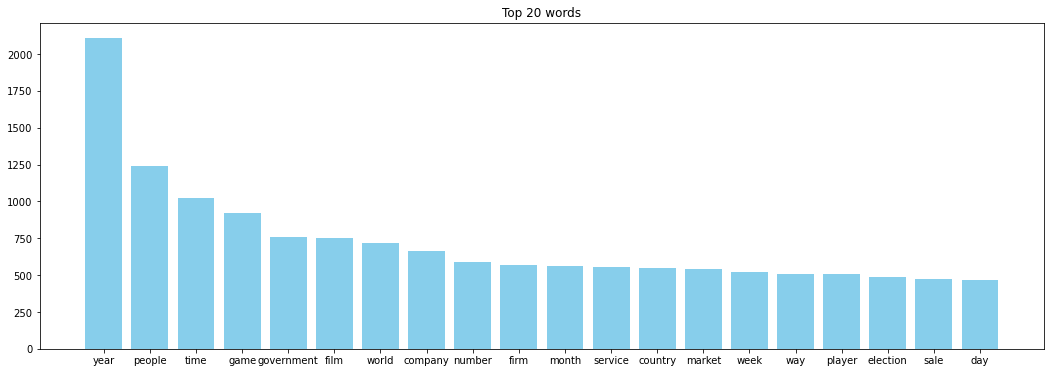

In [20]:
top_words = word_freq_df.iloc[:20]  # appear more than 500 times

plt.figure(figsize=(18, 6))
plt.bar(top_words['Word'], top_words['Frequency'], color='skyblue')
plt.title("Top 20 words")


In [21]:
word_freq_df.describe()

,Frequency
count,9912.000000
mean,13.168886
std,48.538498
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,2107.000000


# Text Vectorization: Converting Text to Numerical Features

To enable computers to process text data, we must convert it into numerical feature vectors, as computers only understand numbers. The process of encoding text into numerical features is known as word vectorization. The method chosen for encoding text data can significantly impact the performance and outcome of machine learning models. Selecting the appropriate word vectorization method is crucial for accurately capturing the nuances of text data and improving the performance of machine learning models.

There are many methods to convert text data to vectors which the model can understand. They include: 

Methods for Text Vectorization:

1. Frequency-Based Word Vectors:
    These methods represent a document by the frequency or presence of words. Common techniques include:

    - One-Hot Encoding: Represents each word as a unique binary vector where only the corresponding word's position is marked as 1, and all others are 0.
    - Bag of Words (BoW): Captures the frequency of each word in a document, ignoring the order of words.
    - Term Frequency-Inverse Document Frequency (TF-IDF): Measures the importance of a word in a document relative to its frequency across all documents. It helps highlight words that are significant in the context of a single document compared to the entire corpus. 



2. Prediction-Based Word Vectors:
    These methods capture both syntactic (structure) and semantic (meaning) relationships between words. They use neural network-based language models to learn these relationships. Known models for word embeddings include:

    - Word2Vec: Learns word representations based on the context in which words appear, using either Continuous Bag of Words (CBOW) or Skip-gram techniques.
    - GloVe (Global Vectors for Word Representation): Uses word co-occurrence statistics from a corpus to learn word vectors.
    - BERT (Bidirectional Encoder Representations from Transformers): Provides contextual embeddings by considering the bidirectional context of words in a sentence.
    - ELMo (Embeddings from Language Models): Generates embeddings by analyzing the context of words in both forward and backward directions within a sentence.


## **Term Frequency - Inverse Document Frequency (TF-IDF)** 

Term Frequency-Inverse Document Frequency (TF-IDF)  is a commonly used technique for tranforming text into a feature vector matrix. TF-IDF effectively captures the significance of terms within individual documents and across the corpus.

**Term frequencies (TF)**

Term Frequency (TF) measures how often a word appears in a document relative to the total number of words in that document. It is calculated as:
$$ \text{Term Frequency (TF)} = \frac{\text{Number of times term appears in a document}}{\text{Total number of terms in the document}} $$

- Advantages: Provides insight into the frequency of terms within a document.
- Disadvantages: Can give too much weight to frequently occurring words that might not be specific or informative.

**Inverse document Frequency (IDF)** 

Inverse Document Frequency (IDF) adjusts the term frequencies by scaling down the weight of words that appear frequently across all documents. It helps highlight words that are more interesting or unique to a specific document. It is calculated as: 
$$ \text{Inverse Document Frequency (IDF)} = \frac{\text{log(Total number of documents)}}{\text{Number of documents using term}} $$

- Advantages: Reduces the importance of common words that appear frequently across all documents, emphasizing more unique terms.

**TF-IDF Calculation**

The TF-IDF score is the product of TF and IDF, representing the importance of a term in a document relative to the entire corpus:
$$ \text{TF-IDF} = \text{TF (term)} * {\text{IDF(term)}} $$



In [22]:
# Convert the categorical variables into qualitative variables 

Encoder = LabelEncoder()
labels = Encoder.fit_transform(df1['Category'])

df1['category_id'] = labels

In [23]:
# exclude terms that appear in less than 2 documents (min_df) or more than 95% (max_df) of the documents.

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95,
                        ngram_range=(1, 2),
                        stop_words='english')


# Apply TF-IDF vectorizer to training set 
features = tfidf.fit_transform(df1.Text_Nouns_only)

# Apply TF-IDF vectorizer to test set
tfidf_test = tfidf.transform(test_set.Text_Nouns_only)

In [24]:
category_id_df = df1[['Category', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

In [25]:
from sklearn.feature_selection import chi2 


N = 5
for Category, category_id in sorted(category_to_id.items()):
    # Chi-squared test
    features_chi2 = chi2(features, labels == category_id)
    
    # Get indices of the features sorted by chi2 score
    indices = np.argsort(features_chi2[0])
    
    # Get the feature names corresponding to these indices
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    
    # Extract unigrams and bigrams
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print(f"\n==> {Category}:")
    print(f"  * Most Correlated Unigrams are: {', '.join(unigrams[-N:])}")
    print(f"  * Most Correlated Bigrams are: {', '.join(bigrams[-N:])}")


==> business:
  * Most Correlated Unigrams are: economy, oil, profit, growth, share
  * Most Correlated Bigrams are: growth year, profit year, consumer spending, oil price, stock market

==> entertainment:
  * Most Correlated Unigrams are: oscar, singer, actor, award, film
  * Most Correlated Bigrams are: film year, dollar baby, film maker, film film, film festival

==> politics:
  * Most Correlated Unigrams are: minister, tory, party, labour, election
  * Most Correlated Bigrams are: labour election, home secretary, council tax, election campaign, lib dem

==> sport:
  * Most Correlated Unigrams are: season, win, injury, champion, match
  * Most Correlated Bigrams are: drug test, world cup, team mate, champion league, world number

==> tech:
  * Most Correlated Unigrams are: pc, technology, computer, software, user
  * Most Correlated Bigrams are: medium player, consumer electronic, mail message, music player, search engine


# Fit NMF Model 

In [26]:

n_topics = 5
random_state = 42

nmf = NMF(n_components=n_topics, random_state=random_state)

W = nmf.fit_transform(features)
H = nmf.components_


feature_names = nmf.get_feature_names_out()
tfidf_features = tfidf.get_feature_names_out()

In [27]:
def topic_table(n_top_words, feature_names, nmf):

    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fidx in topic_vec.argsort()[-1:-n_top_words-1:-1]:
              topic_descr = topic_descr + feature_names[fidx] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'Top_Topic_Terms': topics})


# Label topics with top 5 terms
topic_df = topic_table(8, tfidf.get_feature_names_out(), nmf)
topic_df

,Top_Topic_Terms
0,market company growth share firm economy year ...
1,game player match team time champion win injury
2,film award actor oscar star actress director m...
3,election party labour government minister tory...
4,people user technology phone service computer ...


In [28]:
# Manually Recode the topics 

topic_df['Label'] = ['business', 'sport', 'entertainment', 'politics', 'tech']

topic_df

,Top_Topic_Terms,Label
0,market company growth share firm economy year ...,business
1,game player match team time champion win injury,sport
2,film award actor oscar star actress director m...,entertainment
3,election party labour government minister tory...,politics
4,people user technology phone service computer ...,tech


## Hyperparameter tuning 

In [29]:


# Define the mapping dictionary
# The class values are selected randomly 
mapping_dict = {0: 'business', 1: 'sport', 2: 'entertainment', 3: 'politics', 4: 'tech'}

# Define the hyperparameter grid
param_grid = {
    'init': ['random', 'nndsvd', 'nndsvda', 'nndsvdar'],     # Initialization method
    'solver': ['cd', 'mu'],           # Solver method
    'beta_loss': ['frobenius', 'kullback-leibler']  # Loss function
}

# Prepare a DataFrame to store the results
results = []


# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
     # Skip invalid combinations
    if params['solver'] == 'cd' and params['beta_loss'] != 'frobenius':
        continue  # Skip this iteration if the combination is invalid
        
        
    # Initialize the NMF model with current hyperparameters
    nmf = NMF(
        n_components=5,
        init=params['init'],
        solver=params['solver'],
        beta_loss=params['beta_loss'],
        random_state=42
    )
    
    # Fit the model to the data
    W = nmf.fit_transform(features)
    H = nmf.components_

    # Compute accuracy score    
    y_pred_numeric = W.argmax(axis=1)
    y_pred_categorical = np.array([mapping_dict[value] for value in y_pred_numeric])

    accuracy_recoded = accuracy_score(df1['Category'], y_pred_categorical)
    accuracy_raw = accuracy_score(df1['category_id'], y_pred_numeric)  # results without manually recoding the classes 

    # Record the results
    results.append({
        'init': params['init'],
        'solver': params['solver'],
        'beta_loss': params['beta_loss'],
        'accuracy_recoded' : accuracy_recoded,
        'accuracy_raw' : accuracy_raw
    })

# Convert the results into a DataFrame for easy analysis
NMF_best_params = pd.DataFrame(results)

# Display the best results
best_result = NMF_best_params .loc[NMF_best_params['accuracy_recoded'].idxmax()]
print("Best Hyperparameters:\n", best_result)



C:\Users\Julia\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


Best Hyperparameters:
 init                         nndsvda
solver                            mu
beta_loss           kullback-leibler
accuracy_recoded            0.956944
accuracy_raw                0.373611
Name: 10, dtype: object


In [30]:
NMF_best_params 

,init,solver,beta_loss,accuracy_recoded,accuracy_raw
0,random,cd,frobenius,0.597917,0.540278
1,random,mu,frobenius,0.015972,0.425000
2,nndsvd,cd,frobenius,0.934722,0.361806
3,nndsvd,mu,frobenius,0.931250,0.377778
4,nndsvda,cd,frobenius,0.935417,0.362500
5,nndsvda,mu,frobenius,0.945833,0.372917
6,nndsvdar,cd,frobenius,0.934722,0.361806
7,nndsvdar,mu,frobenius,0.947222,0.373611
8,random,mu,kullback-leibler,0.038194,0.434028
9,nndsvd,mu,kullback-leibler,0.945139,0.377083


## Fit Model on Best Hyperparameters 

In [31]:
n_topics = 5
random_state = 42

# Initialize NMF model
nmf = NMF(n_components=n_topics, 
          init = 'nndsvda', 
          solver = 'mu',
          beta_loss = 'kullback-leibler',
          random_state=random_state)


# Fit and transform the features with NMF
W = nmf.fit_transform(features)  #Topic Distribtions 
H = nmf.components_  # word topic matrix 

# Store most representative topic for each article 
df1["Topic_idx"] = W.argmax(axis=1)

# Join the original dataset with labels
df2 = pd.merge(df1, topic_df, left_on='Topic_idx', right_index=True, how='left')

In [32]:

print("Confusion Matrix:")
print(confusion_matrix(df2['Category'], df2['Label']))
print("\nClassification Report:")
print(classification_report(df2['Category'], df2['Label']))

Confusion Matrix:
[[313   0  11   0  11]
 [  1 254   6   0   2]
 [ 10   2 251   1   2]
 [  1   0   2 339   0]
 [  4   5   2   2 221]]

Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.93      0.94       335
entertainment       0.97      0.97      0.97       263
     politics       0.92      0.94      0.93       266
        sport       0.99      0.99      0.99       342
         tech       0.94      0.94      0.94       234

     accuracy                           0.96      1440
    macro avg       0.96      0.96      0.96      1440
 weighted avg       0.96      0.96      0.96      1440



## Predict Topics on Unseen Data 

In [ ]:
# Predict topics for the test set
y_pred_NMF = nmf.transform(tfidf_test).argmax(axis=1)

# Create a DataFrame for predicted topics
y_pred_NMF_df = pd.DataFrame({"Topic_idx" : y_pred_NMF})

# Merge with topic labels
y_pred_NMF_df_2 = pd.merge(y_pred_df, topic_df, left_on='Topic_idx', right_index=True, how='left')

# Prepare the submission DataFrame
NMF_submission = pd.DataFrame(test_set['ArticleId'])
NMF_submission['Category'] = y_pred_NMF_df_2['Label']
NMF_submission.to_csv('nmf_test_results.csv', index=False)


# Supervised Machine Learning 

The performance of the unsupervised algorithm Non-negative Matrix Factorization will be compared against several supervised algorithms. 
- Logistic Regression
- Multinomial Naive Bayes
- Support Vector Machines
- Random Forest
- Gradient Boosting 

## Model Selection 

In [33]:
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(dual = 'auto'),
    MultinomialNB(),
    LogisticRegression(random_state=0)
    
]
# 5 Cross-validation
CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

classification_reports = {}

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


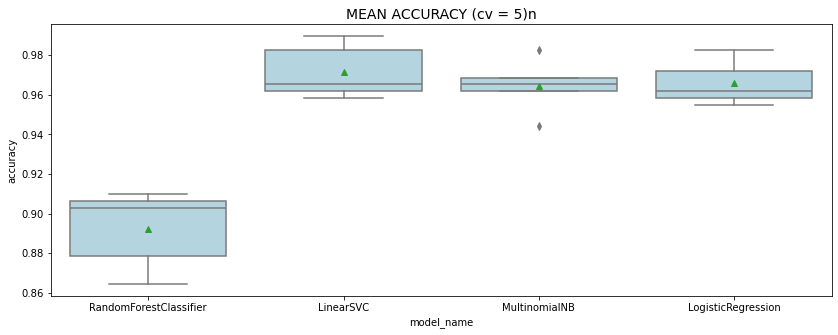

In [34]:
import seaborn as sns

plt.figure(figsize=(14,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14);

In [35]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.971528,0.013758
LogisticRegression,0.965972,0.011358
MultinomialNB,0.964583,0.013758
RandomForestClassifier,0.892361,0.019795


## Multi-Class Classification with LinearSVC

In the evaluation of several machine learning algorithms for text classification, LinearSVC demonstrated the highest performance among the tested models. The LinearSVC model achieved an accuracy score of 0.972, which outperformed other algorithms.

Despite extensive hyperparameter tuning through GridSearchCV, no improvements were observed over the base model results for LinearSVC. This suggests that the default hyperparameters of the LinearSVC model were already well-suited for this particular dataset, or that the model's performance was optimized without the need for further adjustments.

In [36]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df1.index, test_size=0.2,random_state=1)
model = LinearSVC(dual="auto")
model.fit(X_train, y_train)

y_pred_train_test_split = model.predict(X_test)


In [37]:

# Classification report
print('CLASSIFICATIION METRICS')
print(metrics.classification_report(y_test, y_pred_train_test_split, 
                                    target_names= df1['Category'].unique()))

CLASSIFICATIION METRICS
               precision    recall  f1-score   support

     business       0.99      0.97      0.98        69
         tech       1.00      0.96      0.98        47
     politics       0.94      1.00      0.97        50
        sport       1.00      1.00      1.00        77
entertainment       1.00      1.00      1.00        45

     accuracy                           0.99       288
    macro avg       0.99      0.99      0.99       288
 weighted avg       0.99      0.99      0.99       288



## Prediction on Unseen Data

In [ ]:
y_pred_SVC = model.predict(tfidf_test)

SVC_submission = pd.DataFrame(test_set['ArticleId'])
SVC_submission['Category'] = [id_to_category[value] for value in y_pred_SVC]
SVC_submission.to_csv('SVC_test_results.csv', index=False)


# Supervised Learning Model Results (Linear SVC)

In [38]:

training_accuracy = accuracy_score(df1['category_id'], model.predict(features))  # full training set 


print('training accuracy Supervised ML (Linear SVC):', round(training_accuracy, 4))
print('test accuracy Supervised ML (Linear SVC):', 0.976)  # result from kaggle 

training accuracy Supervised ML (Linear SVC): 0.9972
test accuracy Supervised ML (Linear SVC): 0.976


## Compare Data Efficiency 

In [39]:

# Supervised Learning 

split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]  # Train-test split ratios

results = []

for ratio in split_ratios:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=ratio, random_state=0)
    
    model = LinearSVC(dual="auto")
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)
    
    
    # Calculate accuracy
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    
    # Collect results
    results.append({
        'Split Ratio': ratio,
        'Train Accuracy': accuracy_train,
        'Test Accuracy': accuracy_test,
        #'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    })

# Convert results to a DataFrame
results_SVC = pd.DataFrame(results)

In [40]:
results_SVC 


,Split Ratio,Train Accuracy,Test Accuracy
0,0.1,1.0,0.965278
1,0.2,1.0,0.972222
2,0.3,1.0,0.967593
3,0.4,1.0,0.967014
4,0.5,1.0,0.963889


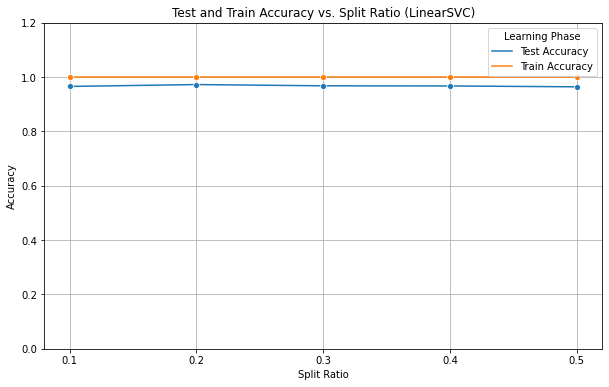

In [41]:
results_SVC_melt = results_SVC.melt(id_vars='Split Ratio', 
                     value_vars=['Test Accuracy', 'Train Accuracy'],
                     var_name='Learning Phase', 
                     value_name='Accuracy')


# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_SVC_melt, x='Split Ratio', y='Accuracy', hue='Learning Phase', marker='o')
plt.ylim(0, 1.2)  # Set y-axis to start from 0 and end at 1

# Customize x-axis ticks
x_ticks = [0.1, 0.2, 0.3, 0.4, 0.5]  # Define the positions for x-axis ticks
plt.xticks(ticks=x_ticks)  # Set x-axis ticks

plt.title('Test and Train Accuracy vs. Split Ratio (LinearSVC)')
plt.xlabel('Split Ratio')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [42]:

n_topics = 5
split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]  # Train-test split ratios

results = []

mapping_dict = {0: 'business', 1: 'sport', 2: 'entertainment', 3: 'politics', 4: 'tech'}

for ratio in split_ratios:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features, df1['Category'], test_size=ratio, random_state=0)
        
        
    # Initialize the NMF model with current hyperparameters
  # Initialize NMF model
    nmf = NMF(n_components=n_topics, 
          init = 'nndsvda', 
          solver = 'mu',
          beta_loss = 'kullback-leibler',
          random_state=random_state)

    
    # Fit the model to the data 
    y_pred_train_raw = nmf.fit_transform(X_train).argmax(axis=1)
    y_pred_train = np.array([mapping_dict[value] for value in y_pred_train_raw])
    

    # Predict test data
    y_pred_test_raw = nmf.transform(X_test).argmax(axis=1)   
    y_pred_test = np.array([mapping_dict[value] for value in y_pred_test_raw])
    
    
    # Compute accuracy score 
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)  

    
    # Collect results
    results.append({
        'Split Ratio': ratio,
        'Train Accuracy': accuracy_train,
        'Test Accuracy': accuracy_test,
        #'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    })

# Convert the results into a DataFrame for easy analysis
results_NMF = pd.DataFrame(results)

In [43]:
results_NMF

,Split Ratio,Train Accuracy,Test Accuracy
0,0.1,0.954475,0.951389
1,0.2,0.947917,0.961806
2,0.3,0.947421,0.958333
3,0.4,0.929398,0.935764
4,0.5,0.286111,0.243056


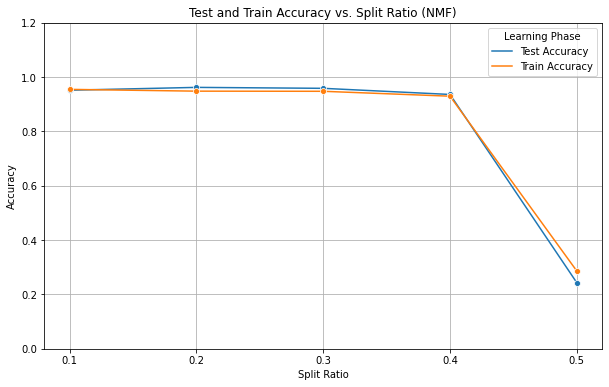

In [44]:
results_NMF_melt = results_NMF.melt(id_vars='Split Ratio', 
                     value_vars=['Test Accuracy', 'Train Accuracy'],
                     var_name='Learning Phase', 
                     value_name='Accuracy')


# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_NMF_melt, x='Split Ratio', y='Accuracy', hue='Learning Phase', marker='o')
plt.ylim(0, 1.2)  # Set y-axis to start from 0 and end at 1
# Customize x-axis ticks
x_ticks = [0.1, 0.2, 0.3, 0.4, 0.5]  # Define the positions for x-axis ticks
plt.xticks(ticks=x_ticks)  # Set x-axis ticks
plt.title('Test and Train Accuracy vs. Split Ratio (NMF)')
plt.xlabel('Split Ratio')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Analysis of Topic Modeling with NMF and Comparison with Supervised Learning 

In [45]:

training_accuracy_NMF = accuracy_score(df2['Category'], df2['Label'])

print('training accuracy NMF:', round(training_accuracy_NMF, 4))
print('test accuracy NMF:', 0.94013)  # result in kaggle 


training_accuracy_SVC = accuracy_score(df1['category_id'], model.predict(features))  # full training set 

print('training accuracy Supervised ML (Linear SVC):', round(training_accuracy_SVC, 4))
print('test accuracy Supervised ML (Linear SVC):', 0.976)  # result from kaggle 

training accuracy NMF: 0.9569
test accuracy NMF: 0.94013
training accuracy Supervised ML (Linear SVC): 0.9819
test accuracy Supervised ML (Linear SVC): 0.976


## Supervised vs. Unsupervised Learning Performance

In our comparison between supervised and unsupervised learning approaches, supervised machine learning algorithms demonstrated superior performance over the unsupervised algorithm Non-Negative Matrix Factorization (NMF). 

- Linear Support Vector Classification (Linear SVC) achieved an impressive accuracy of 0.976 on the test dataset.
- Non-Negative Matrix Factorization (NMF), on the other hand, attained an accuracy of 0.940.


The notable performance of supervised learning can be attributed to its ability to leverage direct supervision, which helps the model learn clear patterns and relationships between inputs and outputs, leading to more accurate predictions. This advantage is evident as supervised models can achieve high accuracy even with a relatively small amount of data, whether it’s 50% or 90% of the dataset.

Conversely, NMF experienced significant challenges when trained on only 50% of the data, with reported accuracies of 0.28 during training and 0.24 during testing. Despite these challenges, NMF still performed remarkably well with an accuracy of 0.94, showcasing its effectiveness even without labels. 

This comparison demonstrates the effectiveness of supervised learning in scenarios where labeled data is available, while also acknowledging the noteworthy capabilities of unsupervised methods like NMF in handling unlabeled data.